<table style="background-color:#FFFFFF">   
  <tr>     
  <td><img src="https://upload.wikimedia.org/wikipedia/commons/9/95/Logo_EPFL_2019.svg" width="150x"/>
  </td>     
  <td>
  <h1> <b>CS-461: Foundation Models and Generative AI</b> </h1>
  Prof. Charlotte Bunne  
  </td>   
  </tr>
</table>

# 📚  Exercise Session (Coding Part) - 2

In this exercise, you will implement, explore and compare three self-supervised training frameworks.

1. **SimCLR (2020)** ([Link to paper](https://arxiv.org/pdf/2002.05709))

2. **BYOL - Bootstrap your own latent (2020)** ([Link to paper](https://arxiv.org/pdf/2006.07733))

3. **Barlow Twins (2021)** ([Link to paper](https://arxiv.org/pdf/2103.03230))

Each of these has introduced important contributions shaping current state-of-the-art self-supervised learning frameworks such as DinoV2.

First, we import the following packages:

In [1]:
import copy
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import math
import os

from torchvision.datasets import CIFAR10
from torchvision.transforms import v2 as T
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as skm
from torchvision.models import resnet18

## 1. Datasets & Transformations

In the following, we will work with the **CIFAR10 dataset**, consisting of 60,000 32x32 color images in 10 classes, with 6,000 images per class.\
There are 50,000 training images and 10,000 test images.

Let's download/load it and define a default transformation turning a PIL Image into a `torch.tensor`


In [2]:
default_transform = T.Compose([
    T.ToTensor(),
])

train = CIFAR10('./data', train=True, download=True, transform=default_transform)
test = CIFAR10('./data', train=False, download=True, transform=default_transform)

/opt/jlab-env/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


Let's have a look at the a few examples. 

#### Task: Visualization
Complete the following code cell to visualize the first 9 images in a 3x3 grid. 

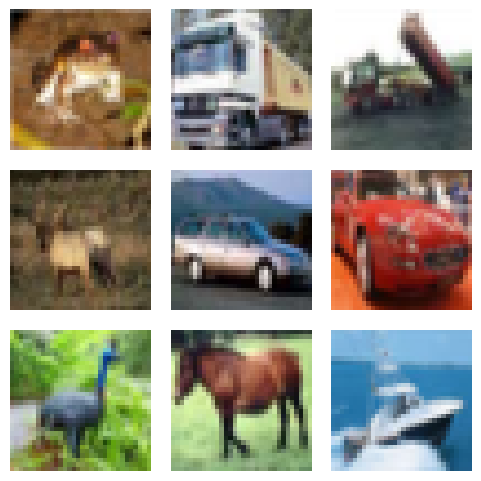

In [3]:
fig = plt.figure(figsize=(6,6))
grid = ImageGrid(fig, 111, nrows_ncols=(3,3), axes_pad=0.2)

for ax, img in zip(grid, train):
    ax.imshow(img[0].permute(1,2,0))
    ax.axis('off')

## 2. Evaluation Pipeline

One challenge in self-supervised training is that the training losses typically do not directly correspond to the model's downstream performance on an actual task of interest, e.g., image classification.

Therefore, we next implement a simple evaluation pipeline, which we will later use to monitor our training progress.

#### Task: Evaluation Tools
Complete the following function `extract_features_and_labels` which encodes all samples provided by the dataloader. If `normalize` is `True` it should additionally L2-normalize each feature vector.

**Caution:** The `forward` pass of our models will later return either a batch of feature vectors of shape `(B,D)` or a `list/tuple`, with the list of features vectors being the first element. Make sure to account for this.

In [4]:
def extract_features_and_labels(model, dataloader, normalize=False):
    """
    Extract features and labels from a dataloader using the given model.
    model: an encoder model taking as input a batch of images (batch_size, channels, height, width) and outputing either a batch of feature vectors (batch_size, feature_dim) or a list/tuple in which the first element is the batch of feature vectors (batch_size, feature_dim)
    dataloader: a PyTorch dataloader providing batches of (images, labels)
    returns: features (num_samples, feature_dim), labels (num_samples,)
    """
    features = []
    labels = []

    for batch in tqdm(dataloader, disable=True):
        x, y = batch
        x = x.to(device)
        with torch.no_grad():
            feat = model(x)
            if type(feat) is tuple or type(feat) is list:
                repr = feat[0]
                feat = repr
        features.append(feat.cpu())
        labels.append(y)

    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)

    if normalize:
        features = F.normalize(features, dim=1)

    return features, labels

Given a classification task at hand, two established routines to evaluate the quality of representations are **Neigheast Neighbour Probes** and **Linear Probes**, in which either a KNN classifier or a logistic regression model is trained and evaluated.

Implement such probes in the following functions `run_knn_probe` and `run_linear_probe`. These functions should return the achieved test accuracy. Feel free to use tools from `sklearn`.

In [5]:
def run_knn_probe(train_features, train_labels, test_features, test_labels):
    """
    Runs a k-NN probe on the given features and labels.
    train_features: (num_train_samples, feature_dim)
    train_labels: (num_train_samples,)
    test_features: (num_test_samples, feature_dim)
    test_labels: (num_test_samples,)
    returns: accuracy (float)
    """
    knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    knn.fit(train_features, train_labels)
    test_preds = knn.predict(test_features)
    accuracy = skm.accuracy_score(test_labels, test_preds)
    return accuracy

def run_linear_probe(train_features, train_labels, test_features, test_labels):
    """
    Runs a linear probe on the given features and labels.
    train_features: (num_train_samples, feature_dim)
    train_labels: (num_train_samples,)
    test_features: (num_test_samples, feature_dim)
    test_labels: (num_test_samples,)
    returns: accuracy (float)
    """
    # TODO
    logreg = LogisticRegression(max_iter=1000, n_jobs=-1)
    logreg.fit(train_features, train_labels)
    test_preds = logreg.predict(test_features)
    accuracy = skm.accuracy_score(test_labels, test_preds)
    return accuracy

Let's test our evaluation pipeline on a randomly initalized ResNet18 model.

In [6]:
model = resnet18(weights=None)
model.fc = nn.Identity()
model = model.to(device)

In [7]:
train_dataloader = DataLoader(train, batch_size=256, shuffle=True, num_workers=10)
test_dataloader = DataLoader(test, batch_size=256, shuffle=False, num_workers=10)

train_features, train_labels = extract_features_and_labels(model, train_dataloader)
test_features, test_labels = extract_features_and_labels(model, test_dataloader)

knn_accuracy = run_knn_probe(train_features.numpy(), train_labels.numpy(), test_features.numpy(), test_labels.numpy())
linear_accuracy = run_linear_probe(train_features.numpy(), train_labels.numpy(), test_features.numpy(), test_labels.numpy())

print(f'k-NN accuracy: {knn_accuracy*100:.2f}%')
print(f'Linear probe accuracy: {linear_accuracy*100:.2f}%')

k-NN accuracy: 24.74%
Linear probe accuracy: 32.75%


Interestingly, we observe that even the representations of a randomly initalized ResNet18 achieve already accuracies far beyond random performance. Keep this observation in mind for later!

## 3. SimCLR

We will start again by implementing **SimCLR** (Simple Framework for Contrastive Learning of Visual Representations), a self-supervised learning method for training deep visual representations without labeled data.\
If you have already sucessfully implemented and trained the SimCLR model in the Exercise Session 1 (Task 3), feel free to skip the implementation part of this section and load your model from last week for the evaluation.

SimCLR is based on the idea of contrastive learning, i.e., the key idea to learn representations by maximizing agreement between differently augmented views of the same image (termed positive pairs) while minimizing agreement between pairs of views of different images (termed negative pairs).  

**Main components:**
1. **Data Augmentation:** Generate two correlated views of the same image (e.g., random crop, color distortion, Gaussian blur).  
2. **Encoder Network:** A deep neural network (commonly ResNet) extracts feature representations from each view.  
3. **Projection Head:** A small MLP maps the representations into a latent space where contrastive loss is applied.  
4. **Contrastive Loss (NT-Xent):** Encourages representations of augmented views of the same image to be close, while pushing apart those of different images.  

#### Augmentations

A key contribution of the SimCLR paper was its systematic study and ablation of image augmentations for contrastive learning. Based on these findings, the SimCLR framework applies the following transformations: random cropping and resizing, horizontal flips, color distortions, grayscale conversion, and Gaussian blur.

We implement these transformations in the following.

In [8]:
class SimCLRTransform:

    def __init__(self, size=32, s=0.5, blur_p=0.5):
        color_jitter = T.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
        k = 3 if size <= 32 else 5
        base = [
            T.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(),
            T.RandomApply([color_jitter], p=0.8),
            T.RandomGrayscale(p=0.2),
            T.RandomApply([T.GaussianBlur(kernel_size=k, sigma=(0.1, 2.0))], p=blur_p),
            T.ToTensor()
        ]
        self.train_transform = T.Compose(base)

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)

def simclr_collate_fn(batch):
    xs1, xs2, ys = [], [], []
    for (x1, x2), y in batch:
        xs1.append(x1)
        xs2.append(x2)
        ys.append(y)
    return torch.stack(xs1), torch.stack(xs2), torch.tensor(ys)

#### Task: SimCLR Model Architecture

In SimCLR, the model architecture consists of two stacked components:  
1. An encoder $f(\cdot)$, e.g., a CNN, that yields the image representation.  
2. A projector head $g(\cdot)$, e.g., an MLP, that yields projections of the image representations. These are used only during training.  

Implement the `forward` pass of the architecture below. Follow the specifications in the docstring. We already provide example network layers (tested for convergence), but feel free to explore alternative (potentially better) configurations!  

**Caution:** Make sure to L2-normalize the projections before returning them.


In [9]:
class SimCLRModel(nn.Module):

    def __init__(self, proj_dim=128, hidden=2048):
        super().__init__()
        enc = resnet18(weights=None)
        enc.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        enc.maxpool = nn.Identity()
        enc.fc = nn.Identity()
        self.encoder = enc

        self.projector = nn.Sequential(
            nn.Linear(512, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, proj_dim) # (bs, proj_dim)
        )

    def normalize(self, x, eps=1e-8):
        """
        Normalizes a batch of feature vectors.
        """
        return x / (x.norm(dim=-1, keepdim=True) + eps)

    def forward(self, x):
        """
        x: (batch_size, channels, height, width) tensor of images
        returns: repr (batch_size, feature_dim), proj (batch_size, proj_dim)
        """
        # TODO
        repr = self.encoder(x)
        proj = self.normalize(self.projector(repr))
        return repr, proj

#### Task: NT-Xent Loss

As mentioned, in SimCLR training we maximize agreement between different views of the same image, while minimizing agreement between views of distinct images. For this, we use the normalized temperature-scaled cross entropy (NT-Xent) loss.

Let $\{x_i\}_{i=1}^{N}$ be a batch of image views, with $x_{2k-1}$ and $x_{2k}$ being views of the same original image.  
For each $i = 1, \dots, N$, we obtain a projected representation $z_i$ as
$$
z_i = g(f(x_i)).
$$

For each positive pair $(i,j)$ and temperature $\tau$, the NT-Xent loss is computed as
$$
\ell_{i,j} = - \log \frac{\exp\big(\mathrm{sim}(\mathbf{z}_i, \mathbf{z}_j)/\tau\big)}
{\sum_{k=1}^{2N} \mathbf{1}_{[k \neq i]} \exp\big(\mathrm{sim}(\mathbf{z}_i, \mathbf{z}_k)/\tau\big)}
$$
and for a complete batch as 
$$
\mathcal{L} = \frac{1}{N} \sum_{k=1}^{N} \ell_{2k-1,2k} + \ell_{2k,2k-1}.
$$

Implement this loss in the following function `nt_xent`.  
It takes as input two tensors of projected representations, `z1` and `z2`, each corresponding to different augmentations of the same batch of images; i.e., for each index `i`, the vectors `z1[i]` and `z2[i]` form a positive pair.


In [10]:
def nt_xent(z1, z2, tau=0.5):
    """
    Computes NT-Xent loss.
    z1: (batch_size, feature_dim) tensor of normalized projection vectors
    z2: (batch_size, feature_dim) tensor of normalized projection vectors
    returns: loss (scalar)
    """
    # TODO
    B, d = z1.shape
    z = torch.cat([z1, z2], dim=0)              # (2B, d)
    sim = (z @ z.t()) / tau                     # (2B, 2B)
    mask = torch.eye(2*B, dtype=torch.bool, device=z.device)
    sim.masked_fill_(mask, -1e9)
    targets = torch.arange(B, device=z.device)
    targets = torch.cat([targets + B, targets], dim=0)
    return F.cross_entropy(sim, targets)

Let us initialize the datasets and dataloaders. For evaluation, we prepare extra dataloaders without the SimCLR augmentations.


In [11]:
simclr_transform = SimCLRTransform(size=32)

train_ds = CIFAR10(root="./data", train=True, download=True, transform=simclr_transform)
test_ds  = CIFAR10(root="./data", train=False, download=True, transform=simclr_transform)

train_loader = DataLoader(train_ds, batch_size=256, num_workers=10, pin_memory=True, collate_fn=simclr_collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=256, num_workers=10, pin_memory=True, collate_fn=simclr_collate_fn)

train_ds_noaugment = CIFAR10(root="./data", train=True, download=True, transform=default_transform)
test_ds_noaugment  = CIFAR10(root="./data", train=False, download=True, transform=default_transform)

train_loader_noaugment = DataLoader(train_ds_noaugment, batch_size=256, shuffle=False, num_workers=10, pin_memory=True)
test_loader_noaugment  = DataLoader(test_ds_noaugment,  batch_size=256, shuffle=False, num_workers=10, pin_memory=True)

/opt/jlab-env/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#### Task: SimCLR Training

Now that all components are ready, it's time to put everything together.  

Complete the training pipeline below and train your SimCLR model.


In [12]:
simclr_model = SimCLRModel(proj_dim=128).to(device)

total_epochs = 50
warmup_epochs = 10

def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return (epoch + 1) / float(warmup_epochs)
    t = (epoch - warmup_epochs) / float(total_epochs - warmup_epochs)
    return 0.0 + 0.5 * (1 - 0.0) * (1 + math.cos(math.pi * t))

optimizer = torch.optim.AdamW(simclr_model.parameters(), lr=0.6, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

all_accuracies = []
all_losses = []
for epoch in range(total_epochs):
    simclr_model.train()
    avg_loss = 0.
    for x1, x2, y in tqdm(train_loader):
        # TODO
        x1, x2 = x1.to(device), x2.to(device)

        _, proj1 = simclr_model(x1)
        _, proj2 = simclr_model(x2)
        loss = nt_xent(proj1, proj2, tau=0.5)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()

    scheduler.step()
    simclr_model.eval()
    train_features, train_labels = extract_features_and_labels(simclr_model, train_loader_noaugment, normalize=True)
    test_features, test_labels = extract_features_and_labels(simclr_model, test_loader_noaugment, normalize=True)
    acc = run_knn_probe(train_features, train_labels, test_features, test_labels)
    avg_loss = avg_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}, kNN Accuracy: {acc:.4f}")
    all_accuracies.append(acc)
    all_losses.append(avg_loss)

os.makedirs('./checkpoints', exist_ok=True)
torch.save(simclr_model.state_dict(), f'./checkpoints/simclr_cifar10.pth')
print('Model saved to ./checkpoints/simclr_cifar10.pth')

100%|██████████| 196/196 [00:39<00:00,  4.92it/s]


Epoch 1, Average Loss: 5.8737, kNN Accuracy: 0.2717


100%|██████████| 196/196 [00:37<00:00,  5.27it/s]


Epoch 2, Average Loss: 5.6072, kNN Accuracy: 0.3131


100%|██████████| 196/196 [00:37<00:00,  5.27it/s]


Epoch 3, Average Loss: 5.4133, kNN Accuracy: 0.3436


100%|██████████| 196/196 [00:37<00:00,  5.26it/s]


Epoch 4, Average Loss: 5.2003, kNN Accuracy: 0.3662


100%|██████████| 196/196 [00:37<00:00,  5.28it/s]


Epoch 5, Average Loss: 5.1318, kNN Accuracy: 0.3968


100%|██████████| 196/196 [00:37<00:00,  5.28it/s]


Epoch 6, Average Loss: 5.0553, kNN Accuracy: 0.4480


100%|██████████| 196/196 [00:37<00:00,  5.26it/s]


Epoch 7, Average Loss: 4.9847, kNN Accuracy: 0.4857


100%|██████████| 196/196 [00:37<00:00,  5.29it/s]


Epoch 8, Average Loss: 4.9556, kNN Accuracy: 0.5128


100%|██████████| 196/196 [00:37<00:00,  5.23it/s]


Epoch 9, Average Loss: 4.9288, kNN Accuracy: 0.5342


100%|██████████| 196/196 [00:37<00:00,  5.25it/s]


Epoch 10, Average Loss: 4.8905, kNN Accuracy: 0.5603


100%|██████████| 196/196 [00:37<00:00,  5.28it/s]


Epoch 11, Average Loss: 4.8544, kNN Accuracy: 0.5839


100%|██████████| 196/196 [00:37<00:00,  5.29it/s]


Epoch 12, Average Loss: 4.8357, kNN Accuracy: 0.5838


100%|██████████| 196/196 [00:37<00:00,  5.22it/s]


Epoch 13, Average Loss: 4.8171, kNN Accuracy: 0.6042


100%|██████████| 196/196 [00:37<00:00,  5.25it/s]


Epoch 14, Average Loss: 4.8057, kNN Accuracy: 0.6246


100%|██████████| 196/196 [00:37<00:00,  5.22it/s]


Epoch 15, Average Loss: 4.7896, kNN Accuracy: 0.6267


100%|██████████| 196/196 [00:37<00:00,  5.25it/s]


Epoch 16, Average Loss: 4.7764, kNN Accuracy: 0.6419


100%|██████████| 196/196 [00:37<00:00,  5.26it/s]


Epoch 17, Average Loss: 4.7698, kNN Accuracy: 0.6425


100%|██████████| 196/196 [00:37<00:00,  5.27it/s]


Epoch 18, Average Loss: 4.7588, kNN Accuracy: 0.6475


100%|██████████| 196/196 [00:37<00:00,  5.23it/s]


Epoch 19, Average Loss: 4.7500, kNN Accuracy: 0.6638


100%|██████████| 196/196 [00:37<00:00,  5.28it/s]


Epoch 20, Average Loss: 4.7415, kNN Accuracy: 0.6733


100%|██████████| 196/196 [00:37<00:00,  5.27it/s]


Epoch 21, Average Loss: 4.7300, kNN Accuracy: 0.6736


100%|██████████| 196/196 [00:37<00:00,  5.25it/s]


Epoch 22, Average Loss: 4.7233, kNN Accuracy: 0.6774


100%|██████████| 196/196 [00:37<00:00,  5.29it/s]


Epoch 23, Average Loss: 4.7172, kNN Accuracy: 0.6896


100%|██████████| 196/196 [00:37<00:00,  5.24it/s]


Epoch 24, Average Loss: 4.7056, kNN Accuracy: 0.6938


100%|██████████| 196/196 [00:36<00:00,  5.31it/s]


Epoch 25, Average Loss: 4.6997, kNN Accuracy: 0.7014


100%|██████████| 196/196 [00:37<00:00,  5.28it/s]


Epoch 26, Average Loss: 4.6912, kNN Accuracy: 0.7012


100%|██████████| 196/196 [00:37<00:00,  5.24it/s]


Epoch 27, Average Loss: 4.6837, kNN Accuracy: 0.7108


100%|██████████| 196/196 [00:37<00:00,  5.26it/s]


Epoch 28, Average Loss: 4.6787, kNN Accuracy: 0.7077


100%|██████████| 196/196 [00:37<00:00,  5.25it/s]


Epoch 29, Average Loss: 4.6722, kNN Accuracy: 0.7095


100%|██████████| 196/196 [00:37<00:00,  5.24it/s]


Epoch 30, Average Loss: 4.6674, kNN Accuracy: 0.7127


100%|██████████| 196/196 [00:37<00:00,  5.27it/s]


Epoch 31, Average Loss: 4.6634, kNN Accuracy: 0.7235


100%|██████████| 196/196 [00:37<00:00,  5.30it/s]


Epoch 32, Average Loss: 4.6564, kNN Accuracy: 0.7189


100%|██████████| 196/196 [00:37<00:00,  5.25it/s]


Epoch 33, Average Loss: 4.6510, kNN Accuracy: 0.7267


100%|██████████| 196/196 [00:37<00:00,  5.28it/s]


Epoch 34, Average Loss: 4.6472, kNN Accuracy: 0.7261


100%|██████████| 196/196 [00:37<00:00,  5.26it/s]


Epoch 35, Average Loss: 4.6423, kNN Accuracy: 0.7301


100%|██████████| 196/196 [00:37<00:00,  5.26it/s]


Epoch 36, Average Loss: 4.6373, kNN Accuracy: 0.7339


100%|██████████| 196/196 [00:37<00:00,  5.29it/s]


Epoch 37, Average Loss: 4.6317, kNN Accuracy: 0.7355


100%|██████████| 196/196 [00:36<00:00,  5.31it/s]


Epoch 38, Average Loss: 4.6284, kNN Accuracy: 0.7438


100%|██████████| 196/196 [00:37<00:00,  5.27it/s]


Epoch 39, Average Loss: 4.6230, kNN Accuracy: 0.7432


100%|██████████| 196/196 [00:37<00:00,  5.26it/s]


Epoch 40, Average Loss: 4.6195, kNN Accuracy: 0.7436


100%|██████████| 196/196 [00:36<00:00,  5.30it/s]


Epoch 41, Average Loss: 4.6157, kNN Accuracy: 0.7495


100%|██████████| 196/196 [00:37<00:00,  5.21it/s]


Epoch 42, Average Loss: 4.6112, kNN Accuracy: 0.7457


100%|██████████| 196/196 [00:37<00:00,  5.22it/s]


Epoch 43, Average Loss: 4.6084, kNN Accuracy: 0.7499


100%|██████████| 196/196 [00:37<00:00,  5.24it/s]


Epoch 44, Average Loss: 4.6021, kNN Accuracy: 0.7475


100%|██████████| 196/196 [00:37<00:00,  5.29it/s]


Epoch 45, Average Loss: 4.6027, kNN Accuracy: 0.7484


100%|██████████| 196/196 [00:37<00:00,  5.26it/s]


Epoch 46, Average Loss: 4.5996, kNN Accuracy: 0.7537


100%|██████████| 196/196 [00:37<00:00,  5.26it/s]


Epoch 47, Average Loss: 4.5988, kNN Accuracy: 0.7513


100%|██████████| 196/196 [00:37<00:00,  5.27it/s]


Epoch 48, Average Loss: 4.5981, kNN Accuracy: 0.7508


100%|██████████| 196/196 [00:37<00:00,  5.26it/s]


Epoch 49, Average Loss: 4.5975, kNN Accuracy: 0.7512


100%|██████████| 196/196 [00:37<00:00,  5.30it/s]


Epoch 50, Average Loss: 4.5969, kNN Accuracy: 0.7521
Model saved to ./checkpoints/simclr_cifar10.pth


Let's visualize the training progress by plotting the loss and accuracy curves!

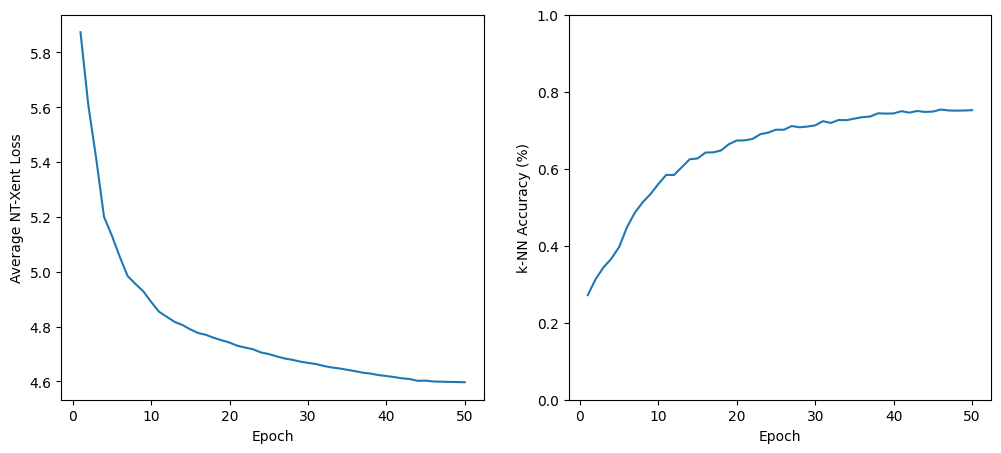

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(range(1, total_epochs+1), all_losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Average NT-Xent Loss')

axes[1].plot(range(1, total_epochs+1), all_accuracies)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('k-NN Accuracy (%)')
axes[1].set_ylim(0, 1)

plt.show()

Let's also run a quick linear probe for the final results!

In [14]:
train_features, train_labels = extract_features_and_labels(simclr_model, train_loader_noaugment, normalize=True)
test_features, test_labels = extract_features_and_labels(simclr_model, test_loader_noaugment, normalize=True)

acc = run_linear_probe(train_features, train_labels, test_features, test_labels)
print(f'Final Linear Probe Accuracy: {acc:.4f}%')
print(f'Final k-NN Accuracy: {all_accuracies[-1]:.4f}%')

Final Linear Probe Accuracy: 0.7790%
Final k-NN Accuracy: 0.7521%


#### Task: Shortcomings
What are potential shortcomings and practical disadvantages of the SimCLR framework?

In [15]:
# TODO

**Solution:**
1. **Large Batch Size Requirement** To get enough negative samples, it typically requires very large batch sizes (e.g., 4096+), leading to high GPU demands.
2. **Sensitive to Augmentations** The quality of learned representations depends heavily on the choice of data augmentations (e.g., color distortion, cropping). Take a look at the original paper for more information.
3. **Inefficient Negative Sampling** SimCLR treats all negatives equally, even if some are more informative (hard negatives) than others.

## 4. BYOL

Next, we will implement **BYOL (Bootstrap Your Own Latent)**, a self-supervised representation learning framework that takes a different approach from contrastive methods.  

Recall our initial observation: even a randomly initialized CNN can produce representations that achieve non-trivial k-NN accuracy. BYOL builds on this insight.  

The key idea is that a given encoder, $f_{\text{target}}$—even if random or mediocre—can serve as a teacher to train a stronger encoder, $f_{\text{online}}$. The training objective is to make $f_{\text{online}}$ imitate the outputs of $f_{\text{target}}$ when both are fed *different augmentations of the same input image*. This process is known as *bootstrapping*.  

Although BYOL still aligns representations of different views of the same image, unlike SimCLR, it is **not strictly contrastive**: it avoids the use of negative examples altogether.


We use the same set of augmentations as in SimCLR.

In [16]:
class BYOLTransform:

    def __init__(self, size=32, s=0.5, blur_p=0.5):
        color_jitter = T.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
        k = 3 if size <= 32 else 5
        base = [
            T.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(),
            T.RandomApply([color_jitter], p=0.8),
            T.RandomGrayscale(p=0.2),
            T.RandomApply([T.GaussianBlur(kernel_size=k, sigma=(0.1, 2.0))], p=blur_p),
            T.ToTensor()
        ]
        self.train_transform = T.Compose(base)

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)


def byol_collate_fn(batch):
    xs1, xs2, ys = [], [], []
    for (x1, x2), y in batch:
        xs1.append(x1)
        xs2.append(x2)
        ys.append(y)
    return torch.stack(xs1), torch.stack(xs2), torch.tensor(ys)

#### Task: BYOL Architecture

The BYOL architecture builds on the SimCLR architecture but introduces a third component on top of the encoder $f(\cdot)$ and the projector head $g(\cdot)$: the predictor head $q(\cdot)$.  

Implement the `forward` pass of the provided `BYOLModel`. It should output three tensors:  
1. The representations $f(x)$,  
2. Their normalized projections $\mathrm{normalize}(g(f(x)))$, and  
3. The normalized predictions $\mathrm{normalize}(q(g(f(x))))$.  


In [17]:
class BYOLModel(nn.Module):

    def __init__(self, proj_dim=128, hidden_dim=2048):
        super().__init__()
        enc = resnet18(weights=None)
        enc.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        enc.maxpool = nn.Identity()
        enc.fc = nn.Identity()
        self.encoder = enc

        self.projector = nn.Sequential(
            nn.Linear(512, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, proj_dim)
        )

        self.predictor = nn.Sequential(
            nn.Linear(proj_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, proj_dim)
        )

    def forward(self, x):
        """
        x: (batch_size, channels, height, width) tensor of images
        returns: repr (batch_size, feature_dim), proj (batch_size, proj_dim), pred (batch_size, proj_dim)
        """
        # TODO
        repr = self.encoder(x)
        proj = self.projector(repr)
        pred = self.predictor(proj)

        proj = F.normalize(proj, dim=-1, eps=1e-8)
        pred = F.normalize(pred, dim=-1, eps=1e-8)

        return repr, proj, pred

Let's initalize our datasets and dataloaders.

In [18]:
byol_transform = BYOLTransform(size=32)

train_ds = CIFAR10(root="./data", train=True, download=True, transform=byol_transform)
test_ds  = CIFAR10(root="./data", train=False, download=True, transform=byol_transform)

train_loader = DataLoader(train_ds, batch_size=256, num_workers=10, pin_memory=True, collate_fn=byol_collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=256, num_workers=10, pin_memory=True, collate_fn=byol_collate_fn)

train_ds_noaugment = CIFAR10(root="./data", train=True, download=True, transform=default_transform)
test_ds_noaugment  = CIFAR10(root="./data", train=False, download=True, transform=default_transform)

train_loader_noaugment = DataLoader(train_ds_noaugment, batch_size=256, shuffle=False, num_workers=10, pin_memory=True)
test_loader_noaugment  = DataLoader(test_ds_noaugment,  batch_size=256, shuffle=False, num_workers=10, pin_memory=True)

/opt/jlab-env/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Let's initialize our models. In BYOL, we train two networks:  
1. The **online network**, and  
2. The **target network**.  

The online network is trained via gradient descent to imitate the target network.  

We initialize both networks with the same weights, but the parameters of the target network are frozen.


In [19]:
online_network = BYOLModel(proj_dim=128).to(device)
target_network = BYOLModel(proj_dim=128).to(device)

target_network.load_state_dict(copy.deepcopy(online_network.state_dict()))
for param in target_network.parameters():
    param.requires_grad = False

#### Task: EMA Update

Given an initially random target network, after some iterations the potential to learn from it via augmentation-invariant imitation will become saturated. Therefore, we need to update the target network as training progresses.  

In BYOL, this is achieved by updating the weights of the target network as an exponential moving average (EMA) of the online network after every optimization step. For each weight $w$ and update rate $\beta$, the update is given by:  
$$
w_{\mathrm{target}} = \beta \, w_{\mathrm{target}} + (1 - \beta) \, w_{\mathrm{online}}
$$

Implement this update rule in the `update` function of the following helper object.

In [20]:
class EMA():

    def __init__(self, beta=0.99):
        self.beta = beta
    
    def update(self, online, target):
        """
        Update target network parameters (inplace) using exponential moving average of online network parameters.
        online: online network (nn.Module)
        target: target network (nn.Module)
        """
        for online_param, target_param in zip(online.parameters(), target.parameters()):
            target_param.data = self.beta * target_param.data + (1 - self.beta) * online_param.data

#### Task: BYOL Training

In the BYOL training loss, the **normalized predictions** of the online network are compared against the **normalized projections** of the target network. See the illustration below. 

![BYOL Diagram](https://raw.githubusercontent.com/lucidrains/byol-pytorch/master/diagram.png)

For an image $x$ and transformations $t, t'$, the loss $\mathcal{L}_{BYOL}(x,t,t')$ computes as 
$$
\mathcal{L}_{BYOL}(x,t,t') 
= \left\| \frac{q_{\theta}(z^{(1)})}{\|q_{\theta}(z^{(1)})\|_2} - \frac{\text{sg}(z^{(2)})}{\|\text{sg}(z^{(2)})\|_2} \right\|_2^2
= 2 - 2 \cdot \frac{\langle q_{\theta}(z^{(1)}), \; \text{sg}(z^{(2)}) \rangle}{\| q_{\theta}(z^{(1)}) \|_2 \, \| \text{sg}(z^{(2)}) \|_2}
$$
where $z^{(1)}$ is the projection of $t(x)$ under the student network and $z^{(2)}$ is the projection of $t'(x)$ under the teacher network.

The total loss for a batch $\{x_i\}_{i=1}^{N}$ reads
$$
\mathcal{L}_{BYOL} = \frac{1}{N}\sum_{i=1}^{N} \mathcal{L}_{BYOL}(x,t,t') + \mathcal{L}_{BYOL}(x,t',t). 
$$

Complete and run the provided training below accordingly.\
*Hint: Don't be surprised if with the provided configuration the model takes a bit longer to converge than SimCLR.*

In [21]:
total_epochs = 50

ema = EMA(beta=0.99)

optimizer = torch.optim.AdamW(online_network.parameters(), lr=0.5, weight_decay=1e-6)


all_accuracies = []
all_losses = []
for epoch in range(total_epochs):
    avg_loss = 0.
    online_network.train()
    for x1, x2, y in tqdm(train_loader):
        # TODO
        x1, x2 = x1.to(device), x2.to(device)

        _, _, pred_online = online_network(torch.concat([x1, x2], dim=0))

        with torch.no_grad():
            _, proj_target, _ = target_network(torch.concat([x2, x1], dim=0))
        
        byol_loss = 2 - 2 * (pred_online * proj_target.detach()).sum(dim=-1)
        byol_loss = byol_loss.mean()

        optimizer.zero_grad()
        byol_loss.backward()
        avg_loss += byol_loss.item()
        optimizer.step()

        ema.update(online_network, target_network)

    online_network.eval()
    train_features, train_labels = extract_features_and_labels(online_network, train_loader_noaugment, normalize=True)
    test_features, test_labels = extract_features_and_labels(online_network, test_loader_noaugment, normalize=True)
    acc = run_knn_probe(train_features, train_labels, test_features, test_labels)
    avg_loss = avg_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}, kNN Accuracy: {acc}")
    all_accuracies.append(acc)
    all_losses.append(avg_loss)

os.makedirs('./checkpoints', exist_ok=True)
torch.save(online_network.state_dict(), f'./checkpoints/byol_cifar10.pth')
print('Model saved to ./checkpoints/byol_cifar10.pth')

100%|██████████| 196/196 [00:47<00:00,  4.15it/s]


Epoch 1, Average Loss: 0.5760, kNN Accuracy: 0.2644


100%|██████████| 196/196 [00:47<00:00,  4.15it/s]


Epoch 2, Average Loss: 0.0125, kNN Accuracy: 0.2564


100%|██████████| 196/196 [00:47<00:00,  4.17it/s]


Epoch 3, Average Loss: 0.0210, kNN Accuracy: 0.2561


100%|██████████| 196/196 [00:46<00:00,  4.20it/s]


Epoch 4, Average Loss: 0.0334, kNN Accuracy: 0.259


100%|██████████| 196/196 [00:46<00:00,  4.18it/s]


Epoch 5, Average Loss: 0.0551, kNN Accuracy: 0.2391


100%|██████████| 196/196 [00:47<00:00,  4.17it/s]


Epoch 6, Average Loss: 0.0957, kNN Accuracy: 0.2125


100%|██████████| 196/196 [00:46<00:00,  4.18it/s]


Epoch 7, Average Loss: 0.1230, kNN Accuracy: 0.2113


100%|██████████| 196/196 [00:46<00:00,  4.19it/s]


Epoch 8, Average Loss: 0.1354, kNN Accuracy: 0.2326


100%|██████████| 196/196 [00:47<00:00,  4.15it/s]


Epoch 9, Average Loss: 0.1191, kNN Accuracy: 0.261


100%|██████████| 196/196 [00:46<00:00,  4.21it/s]


Epoch 10, Average Loss: 0.0990, kNN Accuracy: 0.272


100%|██████████| 196/196 [00:47<00:00,  4.15it/s]


Epoch 11, Average Loss: 0.0942, kNN Accuracy: 0.2968


100%|██████████| 196/196 [00:47<00:00,  4.15it/s]


Epoch 12, Average Loss: 0.0927, kNN Accuracy: 0.3086


100%|██████████| 196/196 [00:46<00:00,  4.20it/s]


Epoch 13, Average Loss: 0.0907, kNN Accuracy: 0.3266


100%|██████████| 196/196 [00:46<00:00,  4.18it/s]


Epoch 14, Average Loss: 0.0904, kNN Accuracy: 0.3395


100%|██████████| 196/196 [00:47<00:00,  4.16it/s]


Epoch 15, Average Loss: 0.0879, kNN Accuracy: 0.3569


100%|██████████| 196/196 [00:47<00:00,  4.15it/s]


Epoch 16, Average Loss: 0.0852, kNN Accuracy: 0.371


100%|██████████| 196/196 [00:47<00:00,  4.16it/s]


Epoch 17, Average Loss: 0.0847, kNN Accuracy: 0.3828


100%|██████████| 196/196 [00:46<00:00,  4.19it/s]


Epoch 18, Average Loss: 0.0804, kNN Accuracy: 0.3877


100%|██████████| 196/196 [00:46<00:00,  4.20it/s]


Epoch 19, Average Loss: 0.0787, kNN Accuracy: 0.4057


100%|██████████| 196/196 [00:47<00:00,  4.14it/s]


Epoch 20, Average Loss: 0.0813, kNN Accuracy: 0.4135


100%|██████████| 196/196 [00:47<00:00,  4.15it/s]


Epoch 21, Average Loss: 0.0826, kNN Accuracy: 0.4399


100%|██████████| 196/196 [00:46<00:00,  4.19it/s]


Epoch 22, Average Loss: 0.0837, kNN Accuracy: 0.4582


100%|██████████| 196/196 [00:46<00:00,  4.19it/s]


Epoch 23, Average Loss: 0.0857, kNN Accuracy: 0.4729


100%|██████████| 196/196 [00:46<00:00,  4.17it/s]


Epoch 24, Average Loss: 0.0854, kNN Accuracy: 0.4874


100%|██████████| 196/196 [00:46<00:00,  4.18it/s]


Epoch 25, Average Loss: 0.0896, kNN Accuracy: 0.4981


100%|██████████| 196/196 [00:47<00:00,  4.15it/s]


Epoch 26, Average Loss: 0.0957, kNN Accuracy: 0.5243


100%|██████████| 196/196 [00:46<00:00,  4.18it/s]


Epoch 27, Average Loss: 0.0967, kNN Accuracy: 0.5343


100%|██████████| 196/196 [00:47<00:00,  4.17it/s]


Epoch 28, Average Loss: 0.1008, kNN Accuracy: 0.5538


100%|██████████| 196/196 [00:47<00:00,  4.15it/s]


Epoch 29, Average Loss: 0.1069, kNN Accuracy: 0.5629


100%|██████████| 196/196 [00:47<00:00,  4.17it/s]


Epoch 30, Average Loss: 0.1089, kNN Accuracy: 0.575


100%|██████████| 196/196 [00:46<00:00,  4.19it/s]


Epoch 31, Average Loss: 0.1098, kNN Accuracy: 0.5776


100%|██████████| 196/196 [00:46<00:00,  4.18it/s]


Epoch 32, Average Loss: 0.1118, kNN Accuracy: 0.5962


100%|██████████| 196/196 [00:46<00:00,  4.19it/s]


Epoch 33, Average Loss: 0.1141, kNN Accuracy: 0.6087


100%|██████████| 196/196 [00:47<00:00,  4.17it/s]


Epoch 34, Average Loss: 0.1167, kNN Accuracy: 0.61


100%|██████████| 196/196 [00:47<00:00,  4.16it/s]


Epoch 35, Average Loss: 0.1191, kNN Accuracy: 0.6292


100%|██████████| 196/196 [00:46<00:00,  4.17it/s]


Epoch 36, Average Loss: 0.1231, kNN Accuracy: 0.6309


100%|██████████| 196/196 [00:46<00:00,  4.18it/s]


Epoch 37, Average Loss: 0.1262, kNN Accuracy: 0.6437


100%|██████████| 196/196 [00:46<00:00,  4.19it/s]


Epoch 38, Average Loss: 0.1262, kNN Accuracy: 0.6432


100%|██████████| 196/196 [00:46<00:00,  4.19it/s]


Epoch 39, Average Loss: 0.1258, kNN Accuracy: 0.6544


100%|██████████| 196/196 [00:46<00:00,  4.20it/s]


Epoch 40, Average Loss: 0.1241, kNN Accuracy: 0.6605


100%|██████████| 196/196 [00:47<00:00,  4.16it/s]


Epoch 41, Average Loss: 0.1211, kNN Accuracy: 0.668


100%|██████████| 196/196 [00:46<00:00,  4.18it/s]


Epoch 42, Average Loss: 0.1214, kNN Accuracy: 0.6699


100%|██████████| 196/196 [00:47<00:00,  4.17it/s]


Epoch 43, Average Loss: 0.1193, kNN Accuracy: 0.678


100%|██████████| 196/196 [00:46<00:00,  4.20it/s]


Epoch 44, Average Loss: 0.1186, kNN Accuracy: 0.6793


100%|██████████| 196/196 [00:46<00:00,  4.17it/s]


Epoch 45, Average Loss: 0.1196, kNN Accuracy: 0.6857


100%|██████████| 196/196 [00:47<00:00,  4.17it/s]


Epoch 46, Average Loss: 0.1204, kNN Accuracy: 0.6873


100%|██████████| 196/196 [00:46<00:00,  4.19it/s]


Epoch 47, Average Loss: 0.1205, kNN Accuracy: 0.696


100%|██████████| 196/196 [00:46<00:00,  4.21it/s]


Epoch 48, Average Loss: 0.1218, kNN Accuracy: 0.6998


100%|██████████| 196/196 [00:47<00:00,  4.17it/s]


Epoch 49, Average Loss: 0.1211, kNN Accuracy: 0.709


100%|██████████| 196/196 [00:47<00:00,  4.17it/s]


Epoch 50, Average Loss: 0.1209, kNN Accuracy: 0.7087
Model saved to ./checkpoints/byol_cifar10.pth


Let's plot the loss and accuracy curves!

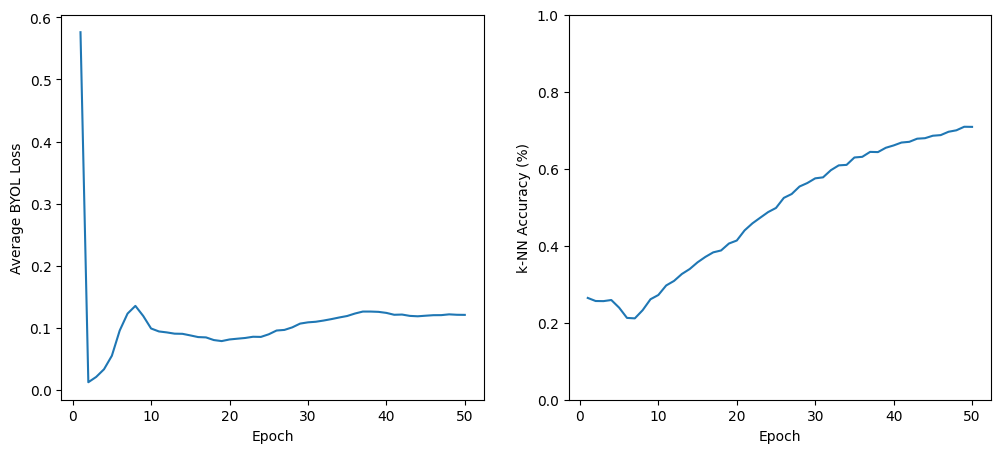

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(range(1, total_epochs+1), all_losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Average BYOL Loss')

axes[1].plot(range(1, total_epochs+1), all_accuracies)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('k-NN Accuracy (%)')
axes[1].set_ylim(0, 1)

plt.show()

Let's also run a quick linear probe for the final results!

In [23]:
train_features, train_labels = extract_features_and_labels(online_network, train_loader_noaugment, normalize=True)
test_features, test_labels = extract_features_and_labels(online_network, test_loader_noaugment, normalize=True)

acc = run_linear_probe(train_features, train_labels, test_features, test_labels)
print(f'Final Linear Probe Accuracy: {acc:.4f}%')
print(f'Final k-NN Accuracy: {all_accuracies[-1]:.4f}%')

Final Linear Probe Accuracy: 0.7348%
Final k-NN Accuracy: 0.7087%


#### Task: On the Role of the Predicor Head

The asymmetry in the BYOL loss—i.e., that the prediction from one view is matched to the projection of the other view—is an important feature of the BYOL architecture.  

**Discussion:** What could be the role of this asymmetry?  

*Hint:* Consider what would happen without the predictor. What would be a local minimum of the loss in that case?


In [24]:
# TODO 

**Solution:** The predictor helps to avoid collapse,  where the model learns to predict a constant representation. This is otherwise a common issue in self-supervised learning based on alignment with out negative examples.

## 5. Barlow Twins

Finally, let us implement **Barlow Twins**. Similar to BYOL, it is a self-supervised learning method that aligns representations of different views of the same images without using negative examples.  

However, it uses only a single network.


#### Augmentations and Architecture

We provide the transformation as well as a model architecture which is very similiar to that of SimCLR.

In [25]:
class BarlowTwinsTransform:

    def __init__(self, size=32, s=0.5, blur_p=0.5):
        color_jitter = T.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
        k = 3 if size <= 32 else 5
        base = [
            T.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(),
            T.RandomApply([color_jitter], p=0.8),
            T.RandomGrayscale(p=0.2),
            T.RandomApply([T.GaussianBlur(kernel_size=k, sigma=(0.1, 2.0))], p=blur_p),
            T.ToTensor()
        ]
        self.train_transform = T.Compose(base)

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)


def barlowtwins_collate_fn(batch):
    xs1, xs2, ys = [], [], []
    for (x1, x2), y in batch:
        xs1.append(x1)
        xs2.append(x2)
        ys.append(y)
    return torch.stack(xs1), torch.stack(xs2), torch.tensor(ys)

In [26]:
class BarlowTwinsModel(nn.Module):

    def __init__(self, proj_dim=128, hidden_dim=2048):
        super().__init__()
        enc = resnet18(weights=None)
        enc.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        enc.maxpool = nn.Identity()
        enc.fc = nn.Identity()
        self.encoder = enc

        self.projector = nn.Sequential(
            nn.Linear(512, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, proj_dim)
        )

    def forward(self, x):
        repr = self.encoder(x)
        proj = self.projector(repr)

        return repr, proj

#### Task: Barlow Twins Loss

Let $z_1, z_2 \in \mathbb{R}^{N\times d}$ be the projected representations of the same images $x$ under different augmentations. The Barlow Twins loss is defined as follows:

Let $\bar{z}_1, \bar{z}_2$ be the batch-normalized projected representations (i.e., zero mean and unit standard deviation along the batch dimension), and let $\mathcal{C}$ be the resulting normalized cross-correlation matrix:  
$$
\mathcal{C} = \frac{\bar{z}_1^T \bar{z}_2}{N}
$$

The Barlow Twins loss is given by:  
$$
\mathcal{L}_{BT} = \sum_{i=1}^{d} \left( 1 - \mathcal{C}_{ii} \right)^2 \;+\; \alpha \sum_{i=1}^{d} \sum_{j \neq i} \mathcal{C}_{ij}^2
$$
where $\alpha$ is a trade-off factor.  

**Questions:**  
1. Hypothesize the role of the two terms in the loss function.  
2. How does this loss avoid collapse to a trivial representation?


In [27]:
# TODO 

**Solution**

**Invariance:** $\sum_i (1 - \mathcal{C}_{ii})^2$ — aligns embeddings of the same image under different augmentations.  
**Redundancy reduction:** $\lambda \sum_{i} \sum_{j \neq i} \mathcal{C}_{ij}^2$ — decorrelates feature dimensions to reduce redundancy.

Collapse is avoided by batch normalizing the projected representations.

Complete the loss function below accordingly.

In [28]:
def off_diagonal(x):
    bs, d = x.shape
    return x.flatten()[:-1].view(bs - 1, bs + 1)[:, 1:].flatten()

def barlow_loss(z1, z2, alpha, eps=1e-5):
    """
    z1: (batch_size, feature_dim) tensor of projection vectors
    z2: (batch_size, feature_dim) tensor of projection vectors
    alpha: redundancy reduction strength (float)
    returns: loss (scalar)
    """
    # TODO 
    B, d = z1.shape
    z1 = (z1 - z1.mean(dim=0, keepdim=True)) / torch.sqrt(z1.var(dim=0, keepdim=True) + eps) # (B, d)
    z2 = (z2 - z2.mean(dim=0, keepdim=True)) / torch.sqrt(z2.var(dim=0, keepdim=True) + eps) #

    cross_corr = z1.T @ z2 / B

    invariance_term = torch.diagonal(cross_corr).add_(-1).pow_(2).sum()
    redundancy_term = off_diagonal(cross_corr).pow_(2).sum()

    loss = invariance_term + alpha * redundancy_term

    return loss

Let's initialize datasets and model.

In [29]:
barlowtwins_transform = BarlowTwinsTransform(size=32)

train_ds = CIFAR10(root="./data", train=True, download=True, transform=barlowtwins_transform)
test_ds  = CIFAR10(root="./data", train=False, download=True, transform=barlowtwins_transform)

train_loader = DataLoader(train_ds, batch_size=256, num_workers=10, pin_memory=True, collate_fn=barlowtwins_collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=256, num_workers=10, pin_memory=True, collate_fn=barlowtwins_collate_fn)

train_ds_noaugment = CIFAR10(root="./data", train=True, download=True, transform=default_transform)
test_ds_noaugment  = CIFAR10(root="./data", train=False, download=True, transform=default_transform)

train_loader_noaugment = DataLoader(train_ds_noaugment, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
test_loader_noaugment  = DataLoader(test_ds_noaugment,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

/opt/jlab-env/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [30]:
barlow_model = BarlowTwinsModel(proj_dim=128).to(device)

#### Task: Barlow Twins Training

Complete the training pipeline below. We suggest $\alpha = 0.005$.

In [31]:
total_epochs = 50

optimizer = torch.optim.AdamW(barlow_model.parameters(), lr=0.5, weight_decay=1e-6)

all_accuracies = []
all_losses = []
for epoch in range(total_epochs):
    barlow_model.train()
    avg_loss = 0.
    for x1, x2, y in tqdm(train_loader):
        # TODO
        x1, x2 = x1.to(device), x2.to(device)

        _, proj1 = barlow_model(x1)
        _, proj2 = barlow_model(x2)

        loss = barlow_loss(proj1, proj2, alpha=0.005)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()

    barlow_model.eval()

    train_features, train_labels = extract_features_and_labels(barlow_model, train_loader_noaugment, normalize=True)
    test_features, test_labels = extract_features_and_labels(barlow_model, test_loader_noaugment, normalize=True)
    acc = run_knn_probe(train_features, train_labels, test_features, test_labels)
    avg_loss = avg_loss / len(train_loader)
    print(f'Epoch {epoch+1}, average loss: {avg_loss/len(train_loader):.4f}, kNN accuracy: {acc:.4f}')

    all_accuracies.append(acc)
    all_losses.append(avg_loss)

os.makedirs('./checkpoints', exist_ok=True)
torch.save(barlow_model.state_dict(), f'./checkpoints/barlowtwins_cifar10.pth')
print('Model saved to ./checkpoints/barlowtwins_cifar10.pth')

100%|██████████| 196/196 [00:37<00:00,  5.19it/s]


Epoch 1, average loss: 0.1670, kNN accuracy: 0.3262


100%|██████████| 196/196 [00:37<00:00,  5.27it/s]


Epoch 2, average loss: 0.1210, kNN accuracy: 0.3496


100%|██████████| 196/196 [00:37<00:00,  5.23it/s]


Epoch 3, average loss: 0.1042, kNN accuracy: 0.3900


100%|██████████| 196/196 [00:37<00:00,  5.19it/s]


Epoch 4, average loss: 0.0897, kNN accuracy: 0.4098


100%|██████████| 196/196 [00:37<00:00,  5.27it/s]


Epoch 5, average loss: 0.0816, kNN accuracy: 0.4115


100%|██████████| 196/196 [00:37<00:00,  5.26it/s]


Epoch 6, average loss: 0.0754, kNN accuracy: 0.4208


100%|██████████| 196/196 [00:37<00:00,  5.25it/s]


Epoch 7, average loss: 0.0695, kNN accuracy: 0.4602


100%|██████████| 196/196 [00:37<00:00,  5.25it/s]


Epoch 8, average loss: 0.0641, kNN accuracy: 0.4713


100%|██████████| 196/196 [00:37<00:00,  5.21it/s]


Epoch 9, average loss: 0.0592, kNN accuracy: 0.4965


100%|██████████| 196/196 [00:37<00:00,  5.29it/s]


Epoch 10, average loss: 0.0556, kNN accuracy: 0.5173


100%|██████████| 196/196 [00:37<00:00,  5.28it/s]


Epoch 11, average loss: 0.0535, kNN accuracy: 0.5212


100%|██████████| 196/196 [00:37<00:00,  5.28it/s]


Epoch 12, average loss: 0.0499, kNN accuracy: 0.5350


100%|██████████| 196/196 [00:37<00:00,  5.27it/s]


Epoch 13, average loss: 0.0476, kNN accuracy: 0.5480


100%|██████████| 196/196 [00:37<00:00,  5.24it/s]


Epoch 14, average loss: 0.0472, kNN accuracy: 0.5535


100%|██████████| 196/196 [00:37<00:00,  5.24it/s]


Epoch 15, average loss: 0.0450, kNN accuracy: 0.5543


100%|██████████| 196/196 [00:37<00:00,  5.28it/s]


Epoch 16, average loss: 0.0431, kNN accuracy: 0.5707


100%|██████████| 196/196 [00:37<00:00,  5.25it/s]


Epoch 17, average loss: 0.0419, kNN accuracy: 0.5760


100%|██████████| 196/196 [00:37<00:00,  5.25it/s]


Epoch 18, average loss: 0.0407, kNN accuracy: 0.5839


100%|██████████| 196/196 [00:37<00:00,  5.21it/s]


Epoch 19, average loss: 0.0397, kNN accuracy: 0.5972


100%|██████████| 196/196 [00:37<00:00,  5.25it/s]


Epoch 20, average loss: 0.0385, kNN accuracy: 0.6138


100%|██████████| 196/196 [00:37<00:00,  5.20it/s]


Epoch 21, average loss: 0.0382, kNN accuracy: 0.6151


100%|██████████| 196/196 [00:37<00:00,  5.22it/s]


Epoch 22, average loss: 0.0376, kNN accuracy: 0.6235


100%|██████████| 196/196 [00:37<00:00,  5.17it/s]


Epoch 23, average loss: 0.0366, kNN accuracy: 0.6294


100%|██████████| 196/196 [00:37<00:00,  5.21it/s]


Epoch 24, average loss: 0.0360, kNN accuracy: 0.6339


100%|██████████| 196/196 [00:37<00:00,  5.23it/s]


Epoch 25, average loss: 0.0348, kNN accuracy: 0.6436


100%|██████████| 196/196 [00:37<00:00,  5.19it/s]


Epoch 26, average loss: 0.0348, kNN accuracy: 0.6518


100%|██████████| 196/196 [00:37<00:00,  5.23it/s]


Epoch 27, average loss: 0.0337, kNN accuracy: 0.6480


100%|██████████| 196/196 [00:37<00:00,  5.21it/s]


Epoch 28, average loss: 0.0332, kNN accuracy: 0.6565


100%|██████████| 196/196 [00:37<00:00,  5.24it/s]


Epoch 29, average loss: 0.0323, kNN accuracy: 0.6587


100%|██████████| 196/196 [00:37<00:00,  5.22it/s]


Epoch 30, average loss: 0.0323, kNN accuracy: 0.6532


100%|██████████| 196/196 [00:37<00:00,  5.18it/s]


Epoch 31, average loss: 0.0315, kNN accuracy: 0.6647


100%|██████████| 196/196 [00:37<00:00,  5.24it/s]


Epoch 32, average loss: 0.0320, kNN accuracy: 0.6724


100%|██████████| 196/196 [00:37<00:00,  5.22it/s]


Epoch 33, average loss: 0.0310, kNN accuracy: 0.6728


100%|██████████| 196/196 [00:37<00:00,  5.22it/s]


Epoch 34, average loss: 0.0300, kNN accuracy: 0.6690


100%|██████████| 196/196 [00:37<00:00,  5.18it/s]


Epoch 35, average loss: 0.0297, kNN accuracy: 0.6775


100%|██████████| 196/196 [00:37<00:00,  5.21it/s]


Epoch 36, average loss: 0.0301, kNN accuracy: 0.6809


100%|██████████| 196/196 [00:37<00:00,  5.24it/s]


Epoch 37, average loss: 0.0298, kNN accuracy: 0.6846


100%|██████████| 196/196 [00:37<00:00,  5.23it/s]


Epoch 38, average loss: 0.0291, kNN accuracy: 0.6815


100%|██████████| 196/196 [00:37<00:00,  5.20it/s]


Epoch 39, average loss: 0.0288, kNN accuracy: 0.6910


100%|██████████| 196/196 [00:37<00:00,  5.19it/s]


Epoch 40, average loss: 0.0282, kNN accuracy: 0.6951


100%|██████████| 196/196 [00:37<00:00,  5.23it/s]


Epoch 41, average loss: 0.0281, kNN accuracy: 0.6946


100%|██████████| 196/196 [00:37<00:00,  5.22it/s]


Epoch 42, average loss: 0.0281, kNN accuracy: 0.7003


100%|██████████| 196/196 [00:37<00:00,  5.18it/s]


Epoch 43, average loss: 0.0276, kNN accuracy: 0.6978


100%|██████████| 196/196 [00:37<00:00,  5.19it/s]


Epoch 44, average loss: 0.0271, kNN accuracy: 0.6950


100%|██████████| 196/196 [00:37<00:00,  5.18it/s]


Epoch 45, average loss: 0.0270, kNN accuracy: 0.7042


100%|██████████| 196/196 [00:37<00:00,  5.18it/s]


Epoch 46, average loss: 0.0267, kNN accuracy: 0.7048


100%|██████████| 196/196 [00:37<00:00,  5.20it/s]


Epoch 47, average loss: 0.0260, kNN accuracy: 0.7027


100%|██████████| 196/196 [00:38<00:00,  5.14it/s]


Epoch 48, average loss: 0.0263, kNN accuracy: 0.7006


100%|██████████| 196/196 [00:37<00:00,  5.23it/s]


Epoch 49, average loss: 0.0254, kNN accuracy: 0.7084


100%|██████████| 196/196 [00:37<00:00,  5.16it/s]


Epoch 50, average loss: 0.0252, kNN accuracy: 0.7111
Model saved to ./checkpoints/barlowtwins_cifar10.pth


Let's plot the loss and accuracy curves!

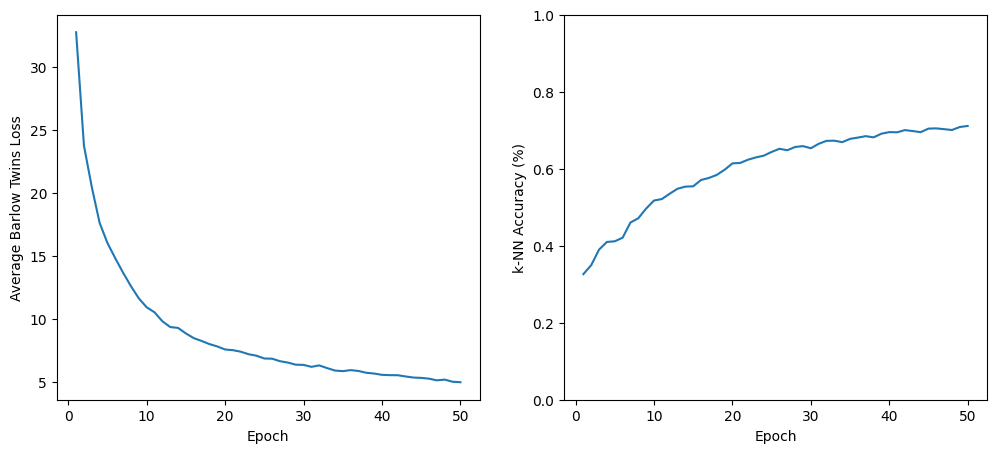

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(range(1, total_epochs+1), all_losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Average Barlow Twins Loss')

axes[1].plot(range(1, total_epochs+1), all_accuracies)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('k-NN Accuracy (%)')
axes[1].set_ylim(0, 1)

plt.show()

Let's evaluate the final linear probe accuracy!

In [33]:
train_features, train_labels = extract_features_and_labels(barlow_model, train_loader_noaugment, normalize=True)
test_features, test_labels = extract_features_and_labels(barlow_model, test_loader_noaugment, normalize=True)

acc = run_linear_probe(train_features, train_labels, test_features, test_labels)
print(f'Final Linear Probe Accuracy: {acc:.4f}%')
print(f'Final k-NN Accuracy: {all_accuracies[-1]:.4f}%')

Final Linear Probe Accuracy: 0.7326%
Final k-NN Accuracy: 0.7111%
